<a href="https://colab.research.google.com/github/lionadis/Easy21/blob/master/Easy21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy.random import choice, rand
from enum import Enum
from copy import copy
from collections import defaultdict
from tqdm import tqdm as tqdm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [0]:
class State:
  def __init__(self, player=0, dealer=0, is_terminated=False):
    self.player = player
    self.dealer = dealer
    self.is_terminated = is_terminated
  
  def tuple(self):
    return (self.player, self.dealer)
  
  def __repr__(self):
    return "({}, {})".format(self.player, self.dealer)

In [0]:
class Action(Enum):
  HIT = 0
  STICK = 1
  
  @staticmethod
  def get_actions():
    return [Action.HIT, Action.STICK]

In [0]:
class Player:

  def action(self, s):
    raise Exception("Needs to be implemented")

In [0]:
class RandomPlayer(Player):
  def action(self, s):
    return choice(Action.get_actions())

In [0]:
class Dealer:
  def action(self, s):
    return Action.HIT if s.dealer < 17 else Action.STICK

In [0]:
class Easy21Env:

  def __init__(self, dealer):
    self.dealer = dealer
  
  def step(self, s, a):
    if s.is_terminated:
      print("Can't take any actions, Game is over")
      return s, 0
    next_s = copy(s)
    if a == Action.HIT:
      next_s.player += self._deal()
      next_s.is_terminated = self._check_bust(next_s.player)
    else:
      while(not next_s.is_terminated and self.dealer.action(next_s) == Action.HIT):
        next_s.dealer += self._deal()
        next_s.is_terminated = self._check_bust(next_s.dealer)
      next_s.is_terminated = True
    return next_s, self._compute_reward(next_s)
  
  def _compute_reward(self, s):
    if not s.is_terminated or s.player == s.dealer:
      return 0
    if s.player > s.dealer:
      return -1 if self._check_bust(s.player) else 1
    else:
      return 1 if self._check_bust(s.dealer) else -1
    
  
  def _check_bust(self, value):
    return value <= 1 or value >= 22
  
  def _deal(self, color=None):
    value = choice(range(1, 11))
    if color:
      coef = 1 if color=='b' else -1
    else:
      coef = choice([1, -1], p=[2.0/3, 1.0/3])
    return value * coef
   
  def reset(self):
      return State(env._deal('b'), env._deal('b'))


In [0]:
env = Easy21Env(Dealer())
player = RandomPlayer()
s = env.reset()
print(s.__dict__)
while not s.is_terminated:
  action = player.action(s)
  s, reward = env.step(s, action)
  print(action)
  print(s.__dict__)
  print(reward)

{'player': 2, 'dealer': 1, 'is_terminated': False}
Action.HIT
{'player': 1, 'dealer': 1, 'is_terminated': True}
0


#Monte-Carlo Control

Repeat forever

1.   Sample the k-th episode using $\pi_t$, $\{S_1,A_1,R_2,.....,S_T\} \sim \pi_t $
2.   $\forall(S_t,A_t)$:
  *   $N(S_t,A_t) \leftarrow N(S_t,A_t) + 1$
  *   $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t,A_t)}(G_t - Q(S_t,A_t))$
3.   $\pi_{t+1} \leftarrow \epsilon{\text -}greedy(Q)$







In [0]:
def plot_value_function(title, v):
  x = np.arange(1, 22)
  y = np.arange(1, 11)
  X, Y = np.meshgrid(x, y)
  def f(x, y):
    xy = np.dstack((x, y))
    res = np.zeros((xy.shape[:2]))
    for i in np.ndindex(xy.shape[:2]):
      res[i] = v[tuple(xy[i])]
    return res
  Z = f(X, Y)
  fig = plt.figure(title, figsize=(10, 5))
  ax = plt.axes(projection='3d')
  ax.plot_surface(Y, X, Z, cmap='viridis')
  ax.set_xlabel('dealer sum')
  ax.set_ylabel('player sum')
  ax.set_zlabel('potential reward')

In [0]:
class MCAgent(Player):
  def __init__(self, N0=100,gamma=1):
    self.Q = defaultdict(int) # State-action value
    self.N = defaultdict(int) # number of time the pair (s, a) is visited
    self.N0 = N0
    self.gamma = gamma # discount factor
    
  def action(self, s):
    '''
      compute the number of times we visisted state s
      N(S) = sum N(s,a) for all a in actions
    '''
    N_total = 0
    actions = Action.get_actions()
    for action in actions:
      N_total += self.N[(s.tuple(), action)]
    '''
      choose a random action with eps probability
    '''
    eps = 1.0 * self.N0 / (self.N0 + N_total)
    if rand() <= eps:
      return choice(actions)
    '''
      else pick the best action, argmax_a Q[(s, a)]
    '''
    best_action, best_value = None, -1e9
    for action in actions:
      if best_value < self.Q[(s.tuple(), action)]:
        best_action, best_value = action, self.Q[(s.tuple(), action)]
    return best_action
  
  def learn(self, h):
    '''
      h: the history of an episode
    '''
    h = h[::-1]
    g_t = 0
    for (s, a, r) in h:
      g_t += r
      self.N[(s.tuple(), a)] += 1
      self.Q[(s.tuple(), a)] += 1.0 / self.N[(s.tuple(),a)] * (g_t - self.Q[(s.tuple(), a)])
  
  def value_function(self):
    v = defaultdict(lambda:-1e9)
    for (s, a), q in self.Q.items():
      v[s] = max(v[s], q)
    return v

In [0]:
def monte_carlo_control(num_episodes=1000000):
  agent = MCAgent()
  wins = 0
  for episode in range(num_episodes):
    env = Easy21Env(Dealer())
    s = env.reset()
    h = [] # history
    while not s.is_terminated:
      a = agent.action(s)
      next_s, r = env.step(s, a)
      h.append((s, a, r))
      s = next_s
    wins += (h[-1][2] == 1)
    agent.learn(h)
    if(episode % 100000 == 0):
      print("episode {} winrate {}".format(episode, 1.0 * wins / (episode + 1)))
  return agent
mc_agent = monte_carlo_control()

episode 0 winrate 0.0
episode 100000 winrate 0.5173848261517385
episode 200000 winrate 0.5237773811130945
episode 300000 winrate 0.5266115779614068
episode 400000 winrate 0.5287436781408047
episode 500000 winrate 0.5300189399621201
episode 600000 winrate 0.5315241141264765
episode 700000 winrate 0.5324335250949641
episode 800000 winrate 0.5330855836430205
episode 900000 winrate 0.5332849630167078


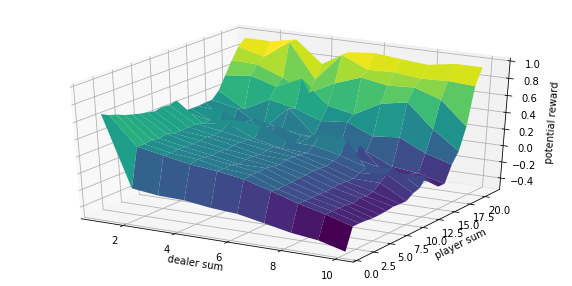

In [0]:
plot_value_function("MC ", mc_agent.value_function())

#Sarsa($\lambda$)
Repeat forver, for each episode
1. $E(s,a) = 0,\forall s \in S, a \in A(s)$
2. Intialize $S, A$
3. Repeat, for each step of episode:
    1. Take action $A$, observe $R, S'$ 
    2. $A' \leftarrow \epsilon{\text -}greedy(Q)(S')$
    3. $\delta \leftarrow R + \gamma Q(S', A') - Q(S,A)$
    4. $E(S, A) \leftarrow E(S,A) + 1$
    5. $\forall s \in S, \forall a \in A(s) :$
      1. $Q(s,a) \leftarrow Q(s,a) + \alpha \delta E(s,a)$
      2. $E(S, A) \leftarrow \gamma \lambda E(S,A)$
4. Until the episode finishes



In [0]:
class SarsaAgent(Player):
  def __init__(self, _lambda, N0=100, gamma=1):
    self.Q = defaultdict(int) # State-action value
    self.N = defaultdict(int) # Number of time the pair (s, a) is visited
    self.E = defaultdict(int) # Eligibility traces
    self.N0 = N0
    self.gamma = gamma # discount factor
    self._lambda = _lambda 
    
  def action(self, s):
    '''
      compute the number of times we visisted state s
      N(S) = sum N(s,a) for all a in actions
    '''
    N_total = 0
    actions = Action.get_actions()
    for action in actions:
      N_total += self.N[(s.tuple(), action)]
    '''
      choose a random action with eps probability
    '''
    eps = 1.0 * self.N0 / (self.N0 + N_total)
    if rand() <= eps:
      return choice(actions)
    '''
      else pick the best action, argmax_a Q[(s, a)]
    '''
    best_action, best_value = None, -1e9
    for action in actions:
      if best_value < self.Q[(s.tuple(), action)]:
        best_action, best_value = action, self.Q[(s.tuple(), action)]
    return best_action
  
  def learn(self, s, a, r, next_s, next_a):
    self.N[(s.tuple(), a)] += 1
    self.N[(next_s.tuple(), next_a)] += 1
    td_error = r + self.gamma * self.Q[(next_s.tuple(), next_a)] - self.Q[(s.tuple(), a)]
    self.E[(s.tuple(), a)] += 1
    for (s, a), e in self.E.items():
      alpha = 1.0 / self.N[(s, a)]
      self.Q[(s, a)] += alpha * td_error * self.E[(s, a)]
      self.E[(s, a)] *= self._lambda * self.gamma
  
  def reset_eligibility_traces(self):
    self.E = defaultdict(int)
  
  def value_function(self):
    v = defaultdict(lambda:-1e9)
    for (s, a), q in self.Q.items():
      v[s] = max(v[s], q)
    return v

In [0]:
def sarsa_lambda_control(agent=None,_lambda=1, num_episodes=1000000, verbose=False):
  if not agent:
    agent = SarsaAgent(_lambda)
  wins = 0
  for episode in range(1, num_episodes + 1):
    env = Easy21Env(Dealer())
    agent.reset_eligibility_traces()
    s = env.reset()
    a = agent.action(s)
    while not s.is_terminated:
      next_s, r = env.step(s, a)
      next_a = agent.action(next_s)
      agent.learn(s, a, r, next_s, next_a)
      s = next_s
      a = next_a
    wins += (r == 1)
    if(episode % (num_episodes / 10) == 0 and verbose):
      print("episode {} winrate {}".format(episode, 1.0 * wins / (episode)))
  return agent

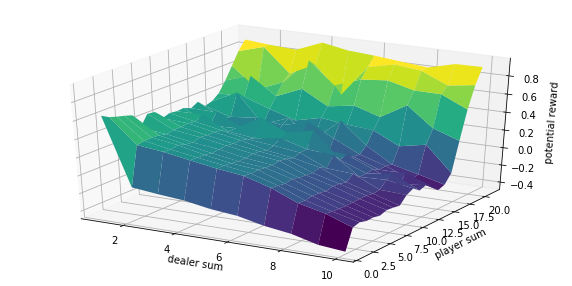

In [0]:
agent = sarsa_lambda_control(_lambda=1)
plot_value_function("Sarsa, lamda = 1, MC", agent.value_function())

In [0]:
def mean_squared_error(q_star, q):
  res = 0;
  for (s, a), v in q_star.items():
    res += (v - q[(s, a)]) ** 2
  return res

In [0]:
lambdas = np.linspace(0, 1, 11)

TOTAL_ITERATIONS = 1000000
EVAL_ITERATION = 1000
mses = []
for idx, _lambda in enumerate(lambdas):
  print("Training for lambda = {}".format(_lambda))
  mses.append([])
  agent = SarsaAgent(_lambda)
  for i in range(TOTAL_ITERATIONS // EVAL_ITERATION):
    agent = sarsa_lambda_control(agent=agent, num_episodes=EVAL_ITERATION)
    mses[idx].append(mean_squared_error(mc_agent.Q, agent.Q))

Training for lambda = 0.0
Training for lambda = 0.1
Training for lambda = 0.2
Training for lambda = 0.30000000000000004
Training for lambda = 0.4
Training for lambda = 0.5
Training for lambda = 0.6000000000000001
Training for lambda = 0.7000000000000001
Training for lambda = 0.8
Training for lambda = 0.9
Training for lambda = 1.0


In [0]:
def plot_mse_against_lambda(mses, lambdas):
  plt.figure("Sarsa error", figsize=(10, 5))
  plt.plot(lambdas, mses)
  plt.show()

In [0]:
def plot_mse_against_number_of_episodes(mses, lambdas, total_iterations, eval_iterations):
  x_range = np.arange(0, total_iterations, eval_iterations)
  plt.figure("MSE against number of episodes", figsize=(10, 5))
  for idx, _lambda in enumerate(lambdas):
    plt.plot(x_range, mses[idx], label="Lambda = {}".format(_lambda))
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

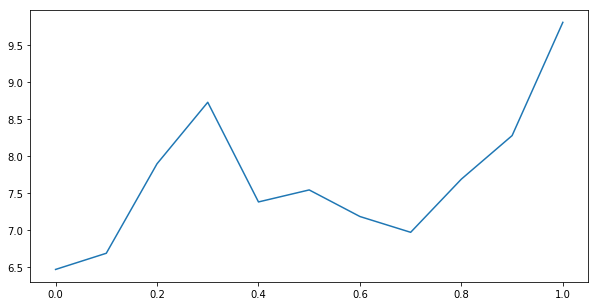

In [0]:
plot_mse_against_lambda([mse[-1] for mse in mses], lambdas)

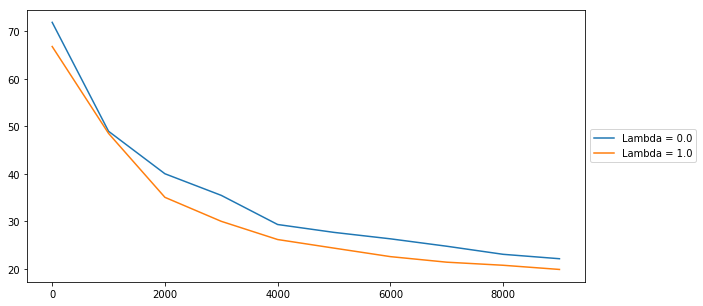

In [0]:
plot_mse_against_number_of_episodes([mses[0], mses[-1]], [lambdas[0], lambdas[-1]], TOTAL_ITERATION, EVAL_ITERATION)

# Linear Function Approximation
The idea is pretty simple, we try to approximate a state value function $V$ using a linear combination of the presented features of a state $x(S)$, and then approximate it using incremental methods such as gradient descent, so the goal is to find a vector $w$ minimsing the MSE, between approximate value function $\hat v(s, w)$  and true value function $v_\pi(s)$
$$J(w) = \mathbb{E}_\pi[(v_\pi(s) - \hat v(s, w)]$$
We use gradiant descent to find the minimum:
$$\Delta w = -\frac{1}{2}\alpha \nabla_wJ(w) $$
$$=\alpha\mathbb{E}_\pi[(v_\pi(s) - \hat v(s, w)]\nabla_w\hat v(s, w)$$
For stochastic gradiant descent:
$$\Delta w=\alpha(v_\pi(s)-\hat v(s,w))\nabla_w\hat v(s, w)$$
We assumed that $v_\pi$ is given by the supervisor, although in RL there is no supervisor, only rewards.
In practice, we substitute a target for $v_\pi(s)$


1.   For MC, the target is the return $G_t$
2.   For TD(0), the target is the TD Target $R_{t+1} + \gamma \hat v(s_{t+1}, w)$
3.   For forward view, TD($\lambda$), the target is the $\lambda$-return $G^{\lambda}_t$

For control, we use state-action value $q(s, a)$, so we just replace value function $v(s)$ by $q(s, a)$ in the gradient descent updates.
Our intreset will be on Sarsa($\lambda$), so the gradient update will be
$$\delta_t = R_{t+1} + \gamma \hat q(s_{t+1},a_{t+1}, w) - \hat q(s_t, a_t, w)$$
$$E_{T} = \gamma \lambda E_{t+1} + \nabla_w \hat q(s_t, a_t, w)$$
$$\Delta w = \alpha \delta_t E_{T}$$

And in this case $$\nabla_w \hat q(s_t, a_t, w) = x(s, a)$$







In [0]:
class LinearFunctionApproximationAgent(Player):
  def __init__(self, _lambda, gamma=1, alpha=0.01, eps=0.05):
    self.w = np.zeros((36)) # Weights vector
    self.E = np.zeros((36)) # Eligibility traces
    self._lambda = _lambda 
    self.gamma = gamma # discount factor
    self.alpha = alpha # step-size
    self.eps = eps # exploration rate

  def phi(self, s, a):
    x = np.zeros((3, 6, 2))
    dealer_x, player_x, action_x = [], [], []
    for (l, r) in zip(range(1, 8, 3), range(4, 11, 3)):
      dealer_x.append(l <= s.dealer <= r)
    for (l, r) in zip(range(1, 17, 3), range(6, 22, 3)):
      player_x.append(l <= s.player <= r)
    for action in Action.get_actions():
      action_x.append(a == action)
    for i in np.where(dealer_x)[0]:
      for j in np.where(player_x)[0]:
        for k in np.where(action_x)[0]:
          x[i, j, k] = 1
    return x.flatten()

  def Q(self, s, a):
    if s.is_terminated:
      return 0
    return np.dot(self.phi(s, a), self.w)

  def action(self, s):
    '''
      compute the number of times we visisted state s
      N(S) = sum N(s,a) for all a in actions
    '''
    actions = Action.get_actions()
    '''
      choose a random action with eps probability
    '''
    if rand() <= self.eps:
      return choice(actions)
    '''
      else pick the best action, argmax_a Q[(s, a)]
    '''
    best_action, best_value = None, -1e9
    for action in actions:
      if best_value < self.Q(s, action):
        best_action, best_value = action, self.Q(s, action)
    return best_action
  
  def learn(self, s, a, r, next_s, next_a):
    td_error = r + self.gamma * self.Q(next_s, next_a) - self.Q(s, a)
    self.E = self.gamma * self._lambda * self.E + self.phi(s, a)
    self.w += self.alpha * td_error * self.E

  def reset_eligibility_traces(self):
    self.E = np.zeros((36))
  
  def value_function(self):
    v = defaultdict(lambda:-1e9)
    for (s, a), q in self.Q.items():
      v[s] = max(v[s], q)
    return v

In [0]:
def lfa_control(agent=None,_lambda=1, num_episodes=100000, verbose=False):
  if not agent:
    agent = LinearFunctionApproximationAgent(_lambda)
  wins = 0
  for episode in range(1, num_episodes + 1):
    env = Easy21Env(Dealer())
    agent.reset_eligibility_traces()
    s = env.reset()
    a = agent.action(s)
    while not s.is_terminated:
      next_s, r = env.step(s, a)
      next_a = agent.action(next_s)
      agent.learn(s, a, r, next_s, next_a)
      s = next_s
      a = next_a
    wins += (r == 1)
    if(episode % (num_episodes / 10) == 0 and verbose):
      print("episode {} winrate {}".format(episode, 1.0 * wins / (episode)))
  return agent

In [0]:
lfa_control(verbose=True)

episode 10000 winrate 0.4981
episode 20000 winrate 0.49825
episode 30000 winrate 0.5020333333333333
episode 40000 winrate 0.5009
episode 50000 winrate 0.5007
episode 60000 winrate 0.5015
episode 70000 winrate 0.5022428571428571
episode 80000 winrate 0.5015875
episode 90000 winrate 0.5018777777777778
episode 100000 winrate 0.50219


In [0]:
def lfa_mean_squared_error(q_star, agent):
  res = 0;
  for (s, a), v in q_star.items():
    res += (v - agent.Q(State(*s), a)) ** 2
  return res

In [0]:
lambdas = np.linspace(0, 1, 11)

TOTAL_ITERATIONS = 100000
EVAL_ITERATION = 1000
mses = []
for idx, _lambda in enumerate(lambdas):
  print("Training for lambda = {}".format(_lambda))
  mses.append([])
  agent = LinearFunctionApproximationAgent(_lambda)
  for i in range(TOTAL_ITERATIONS // EVAL_ITERATION):
    agent = lfa_control(agent=agent, num_episodes=EVAL_ITERATION)
    mses[idx].append(lfa_mean_squared_error(mc_agent.Q, agent))

Training for lambda = 0.0
Training for lambda = 0.1
Training for lambda = 0.2
Training for lambda = 0.30000000000000004
Training for lambda = 0.4
Training for lambda = 0.5
Training for lambda = 0.6000000000000001
Training for lambda = 0.7000000000000001
Training for lambda = 0.8
Training for lambda = 0.9
Training for lambda = 1.0


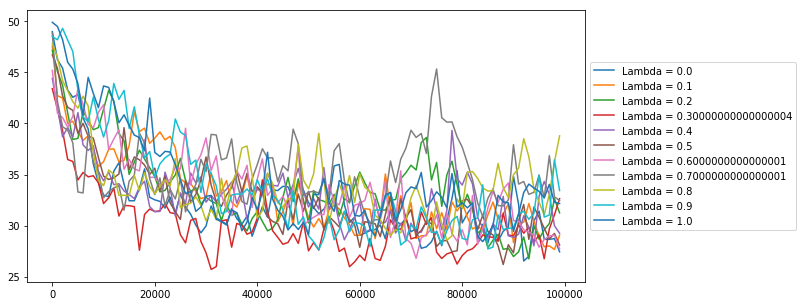

In [0]:
plot_mse_against_number_of_episodes(mses, lambdas, TOTAL_ITERATIONS, EVAL_ITERATION)

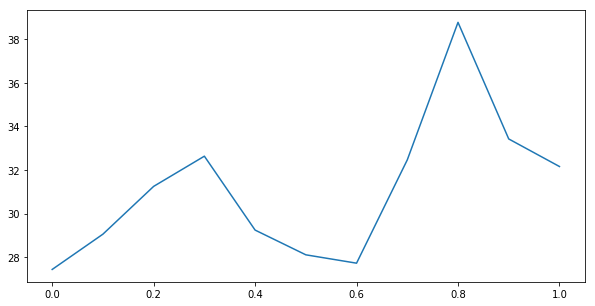

In [0]:
plot_mse_against_lambda([mse[-1] for mse in mses], lambdas)